In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv('final_sample.csv')
df.head()

,pgpub_id,application_id,filing_date,patent_type,filing_type,published_date,wipo_kind,series_code,application_title,application_abstract,...,cpc_sequence,cpc_section,cpc_class,cpc_subclass,cpc_group,cpc_type,cpc_version_indicator,cpc_subclass_title,cpc_group_title,cpc_class_title
0,20110285045,13122899,2009-10-05,utility,NaN,2011-11-24,A1,13,PLASTIC FOAM MOLDING MACHINE MATERIAL CHANGE M...,In a machine for molding coloured plastic foam...,...,7,B,B29,B29C,B29C48/022,additional,2019-02-01,SHAPING OR JOINING OF PLASTICS; SHAPING OF MAT...,"Extrusion moulding, i.e. expressing the mouldi...",WORKING OF PLASTICS; WORKING OF SUBSTANCES IN ...
1,20110308978,13148739,2010-02-09,utility,NaN,2011-12-22,A1,13,DISPOSABLE CIGARETTE-END RECEPTACLE,Disposable cigarette-end receptacle that compr...,...,0,A,A24,A24F,A24F19/14,inventional,2013-01-01,SMOKERS' REQUISITES; MATCH BOXES; SIMULATED SM...,Ash-trays -combined with other articles -with ...,TOBACCO; CIGARS; CIGARETTES; SIMULATED SMOKING...
2,20110104506,13000751,2009-06-18,utility,NaN,2011-05-05,A1,13,Hot Melt Adhesive Compositions And Methods For...,A hot melt adhesive composition can be used to...,...,9,C,C08,C08L,C08L2666/52,inventional,2013-01-01,COMPOSITIONS OF MACROMOLECULAR COMPOUNDS,Composition of polymers characterized by a fur...,ORGANIC MACROMOLECULAR COMPOUNDS; THEIR PREPAR...
3,20150047771,14354980,2012-12-18,utility,NaN,2015-02-19,A1,14,TIRE BUILDING MACHINE AND BOOST TURN-UP METHOD...,The boost turn-up method comprises a belt drum...,...,2,B,B29,B29D,B29D30/2607,inventional,2013-01-01,PRODUCING PARTICULAR ARTICLES FROM PLASTICS OR...,Producing pneumatic or solid tyres or parts th...,WORKING OF PLASTICS; WORKING OF SUBSTANCES IN ...
4,20100015123,12300150,2007-05-11,utility,NaN,2010-01-21,A1,12,NOVEL THROMBOLYTIC MOLECULES AND A PROCESS THE...,New thrombolytic protein molecules such as rec...,...,2,A,A61,A61P,A61P9/10,inventional,2018-01-01,SPECIFIC THERAPEUTIC ACTIVITY OF CHEMICAL COMP...,Drugs for disorders of the cardiovascular syst...,MEDICAL OR VETERINARY SCIENCE; HYGIENE


In [3]:
df['approval_status'] = np.where(df['patent_id'].isnull(), 0, 1)
print(df['approval_status'].head())

0    1
1    0
2    1
3    0
4    1
Name: approval_status, dtype: int64


In [4]:
missing_values_count = df.isnull().sum()

pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  
missing_values_count

pgpub_id                      0
application_id                0
filing_date                   0
patent_type                   0
filing_type                4868
published_date                0
wipo_kind                     0
series_code                   0
application_title             0
application_abstract          0
rule_47_flag                  0
filename                      0
rel_app_text                  0
patent_id                  1700
current_pgpub_id_flag         0
current_patent_id_flag        0
uspc_sequence                 0
uspc_mainclass_id             0
uspc_mainclass_title          0
uspc_subclass_id              0
uspc_subclass_title        1002
published_or_filed_date       0
pct_371_date                412
pct_102_date               4675
filed_country                 0
application_kind              0
pct_doc_number                0
pct_doc_type                  0
wipo_field_sequence           0
wipo_field_id                 0
wipo_sector_title             0
wipo_fie

In [5]:
df.drop(['patent_id', 'filing_type', 'uspc_subclass_title', 'pct_371_date', 'pct_102_date',
        'filename'], axis=1, inplace=True)

In [6]:
missing_values_count = df.isnull().sum()

pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  
missing_values_count

pgpub_id                   0
application_id             0
filing_date                0
patent_type                0
published_date             0
wipo_kind                  0
series_code                0
application_title          0
application_abstract       0
rule_47_flag               0
rel_app_text               0
current_pgpub_id_flag      0
current_patent_id_flag     0
uspc_sequence              0
uspc_mainclass_id          0
uspc_mainclass_title       0
uspc_subclass_id           0
published_or_filed_date    0
filed_country              0
application_kind           0
pct_doc_number             0
pct_doc_type               0
wipo_field_sequence        0
wipo_field_id              0
wipo_sector_title          0
wipo_field_title           0
priority_claim_sequence    0
priority_claim_kind        0
foreign_application_id     0
foreign_filing_date        0
foreign_country_filed      0
cpc_sequence               0
cpc_section                0
cpc_class                  0
cpc_subclass  

In [7]:
# Assuming df is your DataFrame
num_rows, num_cols = df.shape
print("Number of Rows:", num_rows)
print("Number of Columns:", num_cols)


Number of Rows: 5000
Number of Columns: 42


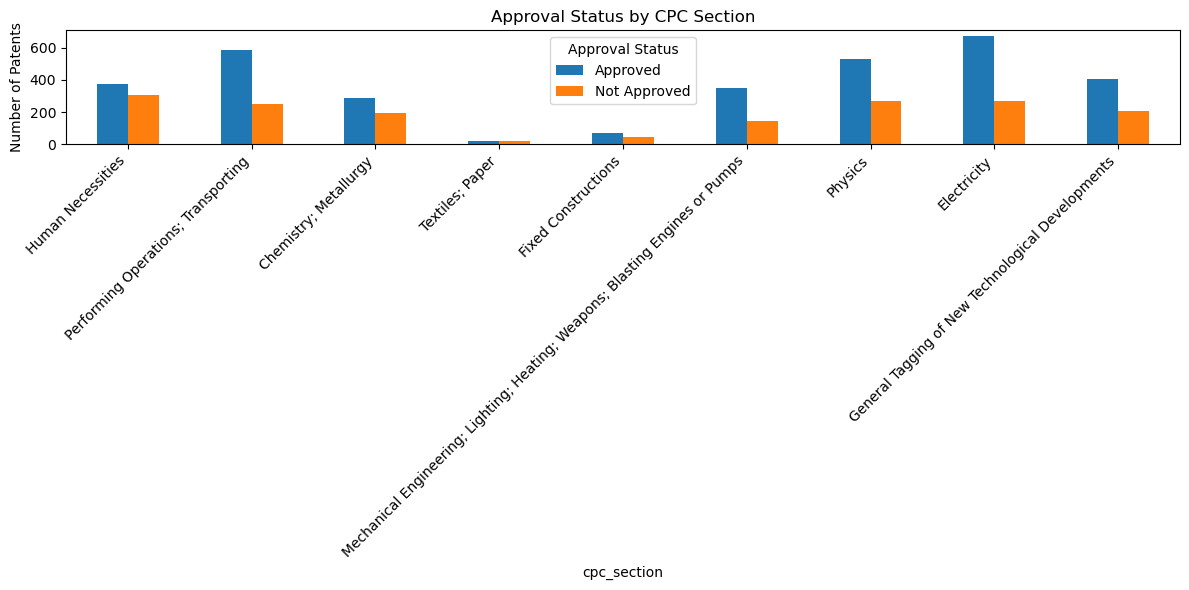

In [8]:
# Define CPC section labels
cpc_labels = {
    'A': 'Human Necessities',
    'B': 'Performing Operations; Transporting',
    'C': 'Chemistry; Metallurgy',
    'D': 'Textiles; Paper',
    'E': 'Fixed Constructions',
    'F': 'Mechanical Engineering; Lighting; Heating; Weapons; Blasting Engines or Pumps',
    'G': 'Physics',
    'H': 'Electricity',
    'Y': 'General Tagging of New Technological Developments'
}

# Define approval status labels
approval_labels = {
    0: 'Not Approved',
    1: 'Approved'
}

# Map approval_status to labels
df['approval_status_label'] = df['approval_status'].map(approval_labels)

# Group data by CPC section and approval status
cpc_approval_counts = df.groupby(['cpc_section', 'approval_status_label']).size().unstack(fill_value=0)

# Plot bar plot
ax = cpc_approval_counts.plot(kind='bar', figsize=(12, 6))

# Set labels for x-axis ticks
ax.set_xticklabels([cpc_labels.get(label, label) for label in cpc_approval_counts.index], rotation=45, ha='right')

# Set labels for y-axis and title
ax.set_ylabel('Number of Patents')
plt.title('Approval Status by CPC Section')

# Set legend
plt.legend(title='Approval Status')

# Show plot
plt.tight_layout()
plt.show()

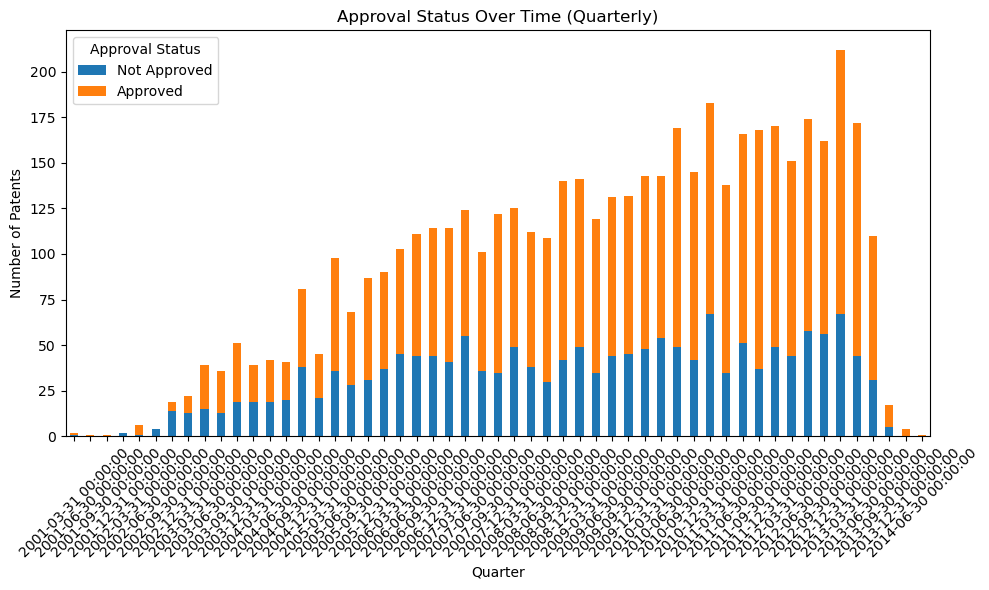

In [9]:
# Assuming df is your DataFrame containing the patent data
# Convert the filing_date_x column to datetime if it's not already in datetime format
df['filing_date'] = pd.to_datetime(df['filing_date'])

# Group the data by quarter and count the number of approvals and rejections for each quarter
approval_counts = df.groupby(pd.Grouper(freq='Q', key='filing_date'))['approval_status'].value_counts().unstack(fill_value=0)

# Plotting
approval_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Approval Status Over Time (Quarterly)')
plt.xlabel('Quarter')
plt.ylabel('Number of Patents')
plt.legend(labels=['Not Approved', 'Approved'], title='Approval Status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
#First Action Interview Pilot Program (16Sep2009). First implemented in 2008
# On September of 2009, the USPTO basically extended the scope of Enhanced First Action Interview Pilot Program.
# Basically, it allows the applicants to interview the examiners ()after examiners have looked at the first set of communicatio
# What it does basically is allow applicant to have more information about its possible approval status

In [11]:
# Print data type of the column
print("Data type of 'current_patent_id_flag':", df['current_patent_id_flag'].dtype)

# Print unique values of the column
print("Unique values of 'current_patent_id_flag':", df['current_patent_id_flag'].unique())


Data type of 'current_patent_id_flag': bool
Unique values of 'current_patent_id_flag': [ True False]


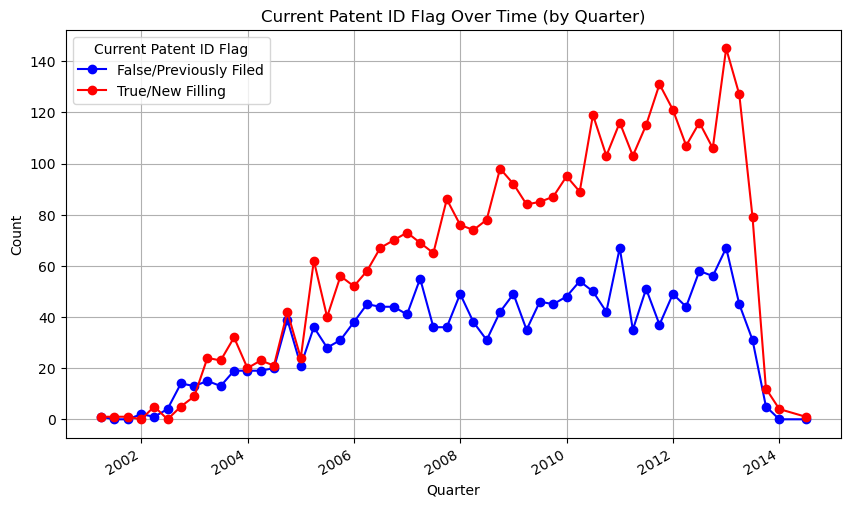

In [12]:
df['filing_date'] = pd.to_datetime(df['filing_date'])

# Resample the data by quarter and count the occurrences of True and False for current_patent_id_flag
flag_counts = df.resample('Q', on='filing_date')['current_patent_id_flag'].value_counts().unstack(fill_value=0)

# Plotting
flag_counts.plot(kind='line', marker='o', figsize=(10, 6), color=['blue', 'red'])
plt.title('Current Patent ID Flag Over Time (by Quarter)')
plt.xlabel('Quarter')
plt.ylabel('Count')
plt.legend(['False/Previously Filed', 'True/New Filling'], title='Current Patent ID Flag')
plt.grid(True)
plt.show()

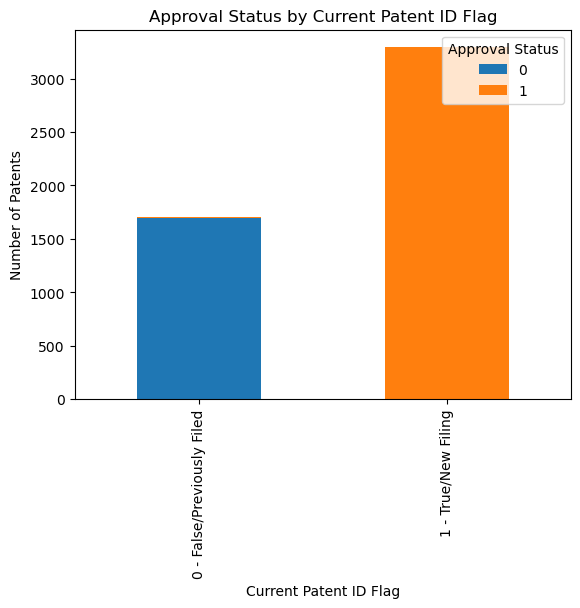

In [13]:
# Mapping labels for current_patent_id_flag
label_map = {False: '0 - False/Previously Filed', True: '1 - True/New Filing'}

# Mapping labels to DataFrame
df['current_patent_id_flag_label'] = df['current_patent_id_flag'].map(label_map)

# Grouping the data by 'current_patent_id_flag' and 'approval_status'
grouped_data = df.groupby(['current_patent_id_flag_label', 'approval_status']).size().unstack()

# Plotting the bar plot
grouped_data.plot(kind='bar', stacked=True)

# Adding labels and title
plt.xlabel('Current Patent ID Flag')
plt.ylabel('Number of Patents')
plt.title('Approval Status by Current Patent ID Flag')

# Adding legend
plt.legend(title='Approval Status', loc='upper right')

# Show plot
plt.show()

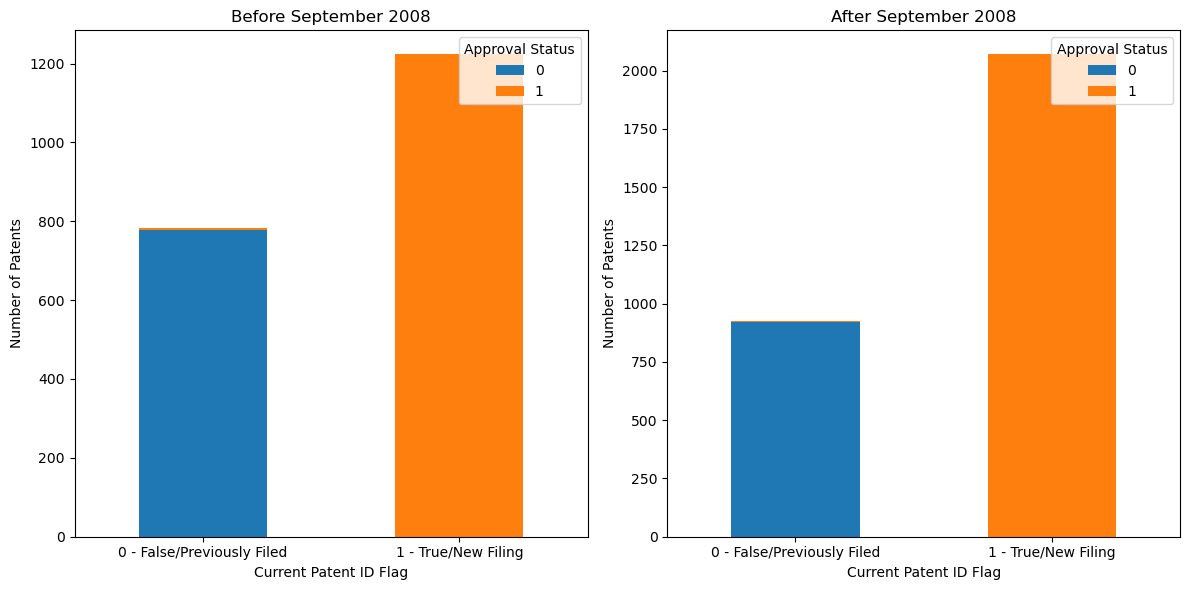

In [14]:
# Mapping labels for current_patent_id_flag
label_map = {False: '0 - False/Previously Filed', True: '1 - True/New Filing'}

# Mapping labels to DataFrame
df['current_patent_id_flag_label'] = df['current_patent_id_flag'].map(label_map)

# Filtering data for patents filed before and after September 2008
df_before_sep_2008 = df[df['filing_date'] < '2008-09-01']
df_after_sep_2008 = df[df['filing_date'] >= '2008-09-01']

# Grouping the data by 'current_patent_id_flag' and 'approval_status' for before September 2008
grouped_data_before = df_before_sep_2008.groupby(['current_patent_id_flag_label', 'approval_status']).size().unstack()

# Grouping the data by 'current_patent_id_flag' and 'approval_status' for after September 2008
grouped_data_after = df_after_sep_2008.groupby(['current_patent_id_flag_label', 'approval_status']).size().unstack()

# Plotting the bar plots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot for before September 2008
axs[0].set_title('Before September 2008')
grouped_data_before.plot(kind='bar', stacked=True, ax=axs[0])
axs[0].set_xlabel('Current Patent ID Flag')
axs[0].set_ylabel('Number of Patents')
axs[0].legend(title='Approval Status', loc='upper right')
axs[0].tick_params(axis='x', rotation=0)

# Plot for after September 2008
axs[1].set_title('After September 2008')
grouped_data_after.plot(kind='bar', stacked=True, ax=axs[1])
axs[1].set_xlabel('Current Patent ID Flag')
axs[1].set_ylabel('Number of Patents')
axs[1].legend(title='Approval Status', loc='upper right')
axs[1].tick_params(axis='x', rotation=0)

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

In [15]:
#Note: Flag indicating whether this row contains the most recent patent_id for a given application 
    #(TRUE = This patent_id refers to the most recent patent granted to this application; 
    #FALSE = This patent application has been withdrawn and re-issued under a more recent patent_id
    
    # for those whose patent has been withdrawn and re-issued under a more recent patent_id, we could 
    # have analyze how their abstarct changed. 
    # This could would have been an interesting quasi-experiment.
    
    #However, for those whose patent has been withdrawn and re-issued under a more recent patent_id, there is no
    # no way to map them to their previous patent ID

<Figure size 2000x1500 with 0 Axes>

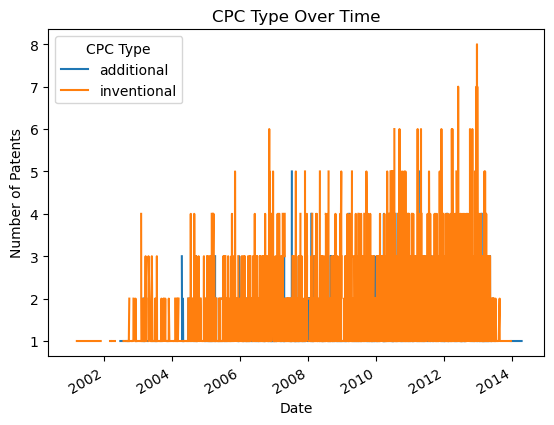

In [16]:
# Set the figure size
plt.figure(figsize=(20, 15))

# Group the data by 'filing_date_x' and 'cpc_type' and count the number of patents
cpc_type_over_time = df.groupby(['filing_date', 'cpc_type']).size().unstack()

# Plot the line plot
cpc_type_over_time.plot(kind='line')

# Add labels and title
plt.title('CPC Type Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Patents')

# Add legend
plt.legend(title='CPC Type', loc='upper left')

# Show plot
plt.show()

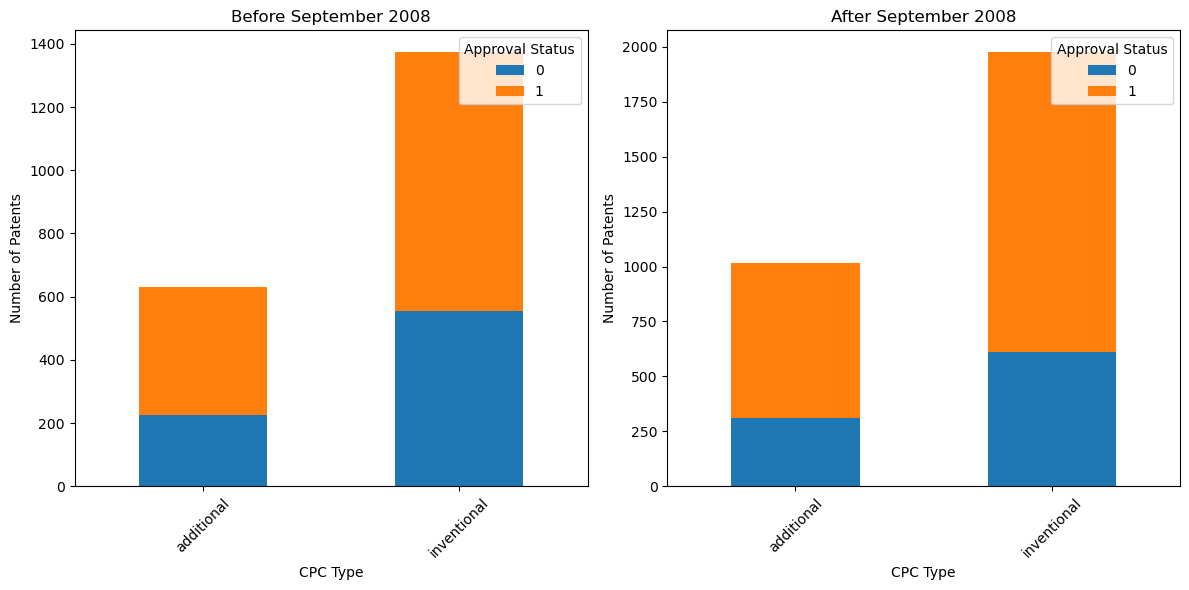

In [17]:
# Filtering data for patents filed before and after September 2008
df_before_sep_2008 = df[df['filing_date'] < '2008-09-01']
df_after_sep_2008 = df[df['filing_date'] >= '2008-09-01']

# Grouping the data by 'cpc_type' and 'approval_status' for before September 2008
grouped_data_before = df_before_sep_2008.groupby(['cpc_type', 'approval_status']).size().unstack()

# Grouping the data by 'cpc_type' and 'approval_status' for after September 2008
grouped_data_after = df_after_sep_2008.groupby(['cpc_type', 'approval_status']).size().unstack()

# Plotting the bar plots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot for before September 2008
axs[0].set_title('Before September 2008')
grouped_data_before.plot(kind='bar', stacked=True, ax=axs[0])
axs[0].set_xlabel('CPC Type')
axs[0].set_ylabel('Number of Patents')
axs[0].legend(title='Approval Status', loc='upper right')
axs[0].tick_params(axis='x', rotation=45)

# Plot for after September 2008
axs[1].set_title('After September 2008')
grouped_data_after.plot(kind='bar', stacked=True, ax=axs[1])
axs[1].set_xlabel('CPC Type')
axs[1].set_ylabel('Number of Patents')
axs[1].legend(title='Approval Status', loc='upper right')
axs[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

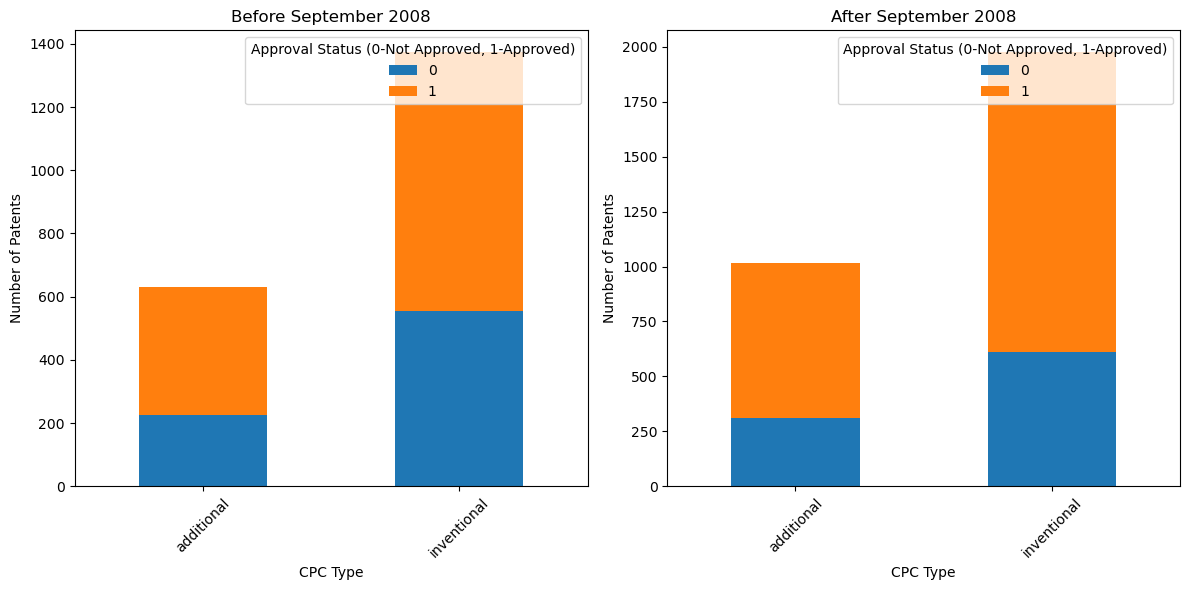

In [18]:
# Filtering data for patents filed before and after September 2008
df_before_sep_2008 = df[df['filing_date'] < '2008-09-01']
df_after_sep_2008 = df[df['filing_date'] >= '2008-09-01']

# Grouping the data by 'cpc_type' and 'approval_status' for before September 2008
grouped_data_before = df_before_sep_2008.groupby(['cpc_type', 'approval_status']).size().unstack()

# Grouping the data by 'cpc_type' and 'approval_status' for after September 2008
grouped_data_after = df_after_sep_2008.groupby(['cpc_type', 'approval_status']).size().unstack()

# Plotting the bar plots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot for before September 2008
axs[0].set_title('Before September 2008')
grouped_data_before.plot(kind='bar', stacked=True, ax=axs[0])
axs[0].set_xlabel('CPC Type')
axs[0].set_ylabel('Number of Patents')
axs[0].legend(title='Approval Status (0-Not Approved, 1-Approved)', loc='upper right')
axs[0].tick_params(axis='x', rotation=45)

# Plot for after September 2008
axs[1].set_title('After September 2008')
grouped_data_after.plot(kind='bar', stacked=True, ax=axs[1])
axs[1].set_xlabel('CPC Type')
axs[1].set_ylabel('Number of Patents')
axs[1].legend(title='Approval Status (0-Not Approved, 1-Approved)', loc='upper right')
axs[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

In [19]:
# Date Variables
date_vars = ['filing_date', 'published_date', 'published_or_filed_date', 'foreign_filing_date']

for col in date_vars:
    df[col + '_month'] = pd.to_datetime(df[col]).dt.month
    df[col + '_year'] = pd.to_datetime(df[col]).dt.year

# Drop original date and categorical variables
#df.drop(date_vars + cat_vars, axis=1, inplace=True)
df.drop(date_vars, axis=1, inplace=True)

In [20]:
# For y_train
approval_class_counts = df['approval_status'].value_counts()
print("Number of observations for y values in train data:")
print(approval_class_counts)

Number of observations for y values in train data:
approval_status
1    3300
0    1700
Name: count, dtype: int64


In [21]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load DataFrame
# Assuming your DataFrame is already loaded and named 'df'

# Preprocessing function
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove punctuation and convert to lowercase
    tokens = [word.lower() for word in tokens if word.isalpha()]
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    
    # Lemmatization
    #lemmatizer = WordNetLemmatizer()
    #tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back into a single string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

# Apply preprocessing to application_abstract column
df['application_abstract'] = df['application_abstract'].apply(preprocess_text)

# Apply preprocessing to rel_app_text column
df['rel_app_text'] = df['rel_app_text'].apply(preprocess_text)

# Calculate total number of unique words in the entire dataset
total_unique_words = len(set(' '.join(df['application_abstract']).split()))

# Calculate average number of unique words per patent application
average_unique_words_per_application = total_unique_words / len(df)

# Tokenize each abstract and count the number of words for each patent application
df['word_count'] = df['application_abstract'].apply(lambda x: len(x.split()))

# Calculate average number of words for every patent application
average_words_per_application = df['word_count'].mean()

print("Total unique words in the entire dataset:", total_unique_words)
print("Average number of words in patent application abstract:", average_words_per_application)
print("Average unique words per patent application abstract:", average_unique_words_per_application)

# Calculate total number of unique words in the entire dataset
total_unique_words1 = len(set(' '.join(df['rel_app_text']).split()))

# Calculate average number of unique words per patent application
average_unique_words_per_application1 = total_unique_words1 / len(df)

# Tokenize each abstract and count the number of words for each patent application
df['word_count1'] = df['rel_app_text'].apply(lambda x: len(x.split()))

# Calculate average number of words for every patent application
average_words_per_application1 = df['word_count1'].mean()

print("Total unique words in the entire dataset for related text:", total_unique_words1)
print("Average number of words in patent related application text:", average_words_per_application1)
print("Average unique words per patent related application text:", average_unique_words_per_application1)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/harshikhaagarwal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/harshikhaagarwal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/harshikhaagarwal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Total unique words in the entire dataset: 8829
Average number of words in patent application abstract: 61.994
Average unique words per patent application abstract: 1.7658
Total unique words in the entire dataset for related text: 2619
Average number of words in patent related application text: 25.1232
Average unique words per patent related application text: 0.5238


In [22]:
# Splitting the data into features (X) and target (y)
X = df.drop(['approval_status'], axis=1)  # Adjust the column name accordingly
y = df['approval_status']  # Adjust the column name accordingly

# Performing a universal split on the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=34)

In [23]:
from sklearn.utils import resample
# Downsample majority class to match minority class in the training set
X_train_undersampled, y_train_undersampled = resample(X_train[y_train == 1],  # Selecting majority class samples
                                                      y_train[y_train == 1],  # Selecting corresponding labels
                                                      replace=False,          # Sampling without replacement
                                                      n_samples=sum(y_train == 0),  # Number of samples from minority class
                                                      random_state=25)        # Set random state for reproducibility

# Concatenate minority class samples with downsampled majority class samples
X_train_undersampled = pd.concat([X_train[y_train == 0], X_train_undersampled])
y_train_undersampled = pd.concat([y_train[y_train == 0], y_train_undersampled])

In [24]:
# TF-IDF vectorization for application abstracts on training and testing sets separately
abstract_tfidf_vectorizer = TfidfVectorizer()
X_train_abstract_tfidf = abstract_tfidf_vectorizer.fit_transform(X_train_undersampled['application_abstract'])
X_test_abstract_tfidf = abstract_tfidf_vectorizer.transform(X_test['application_abstract'])

# TF-IDF vectorization for rel_app_text on training and testing sets separately
rel_app_text_tfidf_vectorizer = TfidfVectorizer()
X_train_rel_app_text_tfidf = rel_app_text_tfidf_vectorizer.fit_transform(X_train_undersampled['rel_app_text'])
X_test_rel_app_text_tfidf = rel_app_text_tfidf_vectorizer.transform(X_test['rel_app_text'])

# Now you can use X_train_abstract_tfidf, X_test_abstract_tfidf,
# X_train_rel_app_text_tfidf, and X_test_rel_app_text_tfidf in your modeling process

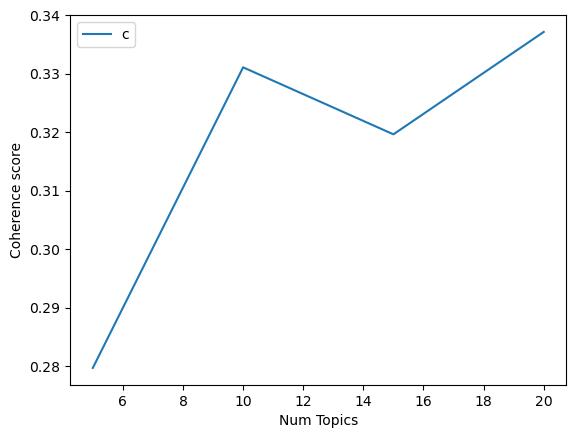

Optimal number of topics: 20
Topic 0:
dioxid shift oxygen reform mutat pci microscop manag expand occlud
Topic 1:
server network manag subscrib commun key frequenc user bead uplink
Topic 2:
waveguid speed fan mail aerodynam stream agit bath inspect carousel
Topic 3:
clutch torqu gear conveyor printer blood bush payment lid beam
Topic 4:
compound resin pharmaceut composit diseas invent acid energi present salt
Topic 5:
armatur particul spindl condens bridg transduc egg drum purifi dowel
Topic 6:
crystallin copolym ethylen molecular amorph propylen backup spacecraft protein silica
Topic 7:
friction shift graphit filler blind cargo vapor retard braze salinomycin
Topic 8:
tape closur weld binder atmospher voxel coolant condens refract laser
Topic 9:
clean smoke solder nox stroke explos electrochem tilt straight piezoresistor
Topic 10:
power voltag connector speed calcul segment energi ion frequenc charg
Topic 11:
brake nozzl cabl sleev rod drill hydraul park instrument leaf
Topic 12:
gears

In [30]:
# Define a function to calculate coherence score for LDA
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=5):
    coherence_values = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    return coherence_values

# Create Dictionary object
dictionary = Dictionary(X_train_undersampled['application_abstract'].apply(lambda x: x.split(' ')))

# Create Corpus object
corpus = [dictionary.doc2bow(doc) for doc in X_train_undersampled['application_abstract'].apply(lambda x: x.split(' '))]

# Determine the range of values for n_components
start = 5
limit = 25
step = 5

# Calculate coherence scores for different values of n_components
coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, 
                                            texts=X_train_undersampled['application_abstract'].apply(lambda x: x.split(' ')), 
                                            start=start, limit=limit, step=step)

# Plot coherence scores to visualize the optimal number of topics
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Choose the optimal number of topics based on the plot
optimal_num_topics = x[np.argmax(coherence_values)]
print("Optimal number of topics:", optimal_num_topics)

# Fit LDA model with optimal number of topics
lda_model = LatentDirichletAllocation(n_components=optimal_num_topics, random_state=42)
lda_model.fit(X_train_abstract_tfidf)

# Display the top words for each topic
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

num_top_words = 10  # Adjust the number of top words to display
feature_names = abstract_tfidf_vectorizer.get_feature_names_out()  # Assuming abstract_tfidf_vectorizer is your vectorizer
display_topics(lda_model, feature_names, num_top_words)

In [31]:
# Create Dictionary object for the test dataset
dictionary_test = Dictionary(X_test['application_abstract'].apply(lambda x: x.split(' ')))

# Create Corpus object for the test dataset
corpus_test = [dictionary_test.doc2bow(doc) for doc in X_test['application_abstract'].apply(lambda x: x.split(' '))]

# Transform the test dataset using the pre-trained LDA model
topic_dist_test = lda_model.transform(X_test_abstract_tfidf)

# Display the top words for each topic in the test dataset
def display_topics_test(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

num_top_words = 10  # Adjust the number of top words to display
feature_names = abstract_tfidf_vectorizer.get_feature_names_out()  # Assuming abstract_tfidf_vectorizer is your vectorizer
display_topics_test(lda_model, feature_names, num_top_words)

Topic 0:
dioxid shift oxygen reform mutat pci microscop manag expand occlud
Topic 1:
server network manag subscrib commun key frequenc user bead uplink
Topic 2:
waveguid speed fan mail aerodynam stream agit bath inspect carousel
Topic 3:
clutch torqu gear conveyor printer blood bush payment lid beam
Topic 4:
compound resin pharmaceut composit diseas invent acid energi present salt
Topic 5:
armatur particul spindl condens bridg transduc egg drum purifi dowel
Topic 6:
crystallin copolym ethylen molecular amorph propylen backup spacecraft protein silica
Topic 7:
friction shift graphit filler blind cargo vapor retard braze salinomycin
Topic 8:
tape closur weld binder atmospher voxel coolant condens refract laser
Topic 9:
clean smoke solder nox stroke explos electrochem tilt straight piezoresistor
Topic 10:
power voltag connector speed calcul segment energi ion frequenc charg
Topic 11:
brake nozzl cabl sleev rod drill hydraul park instrument leaf
Topic 12:
gearset hose fibr write nitrid clu

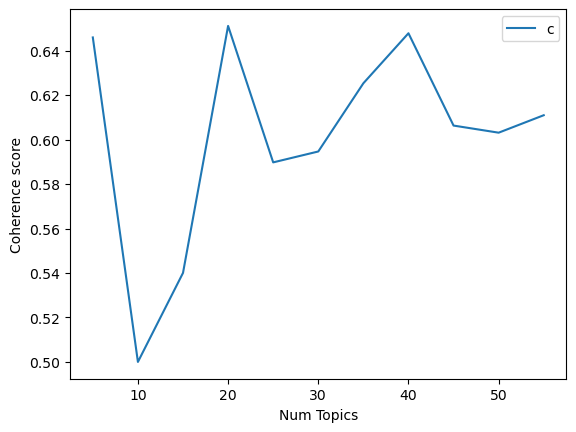

Optimal number of topics: 20
Topic 0:
fr indian itali therefrom accru titl devic section code reli
Topic 1:
part made appln sweden hereof eapo pv czech system spain
Topic 2:
applic file benefit intern refer claim cross patent nation herein
Topic 3:
document expressli applic foreign file italian disclosur de incorpor patent
Topic 4:
util thereto gm model moreov definit belgian term mark measur
Topic 5:
applic japanes file publish public intern wo languag disclosur refer
Topic 6:
pursuant applic date file provision section benefit hereto polish provis
Topic 7:
continu whole norwegian inventor electroluminesc take spread entitl process materi
Topic 8:
method titl use structur entitl apparatu manufactur semiconductor uk devic
Topic 9:
ser applic provision file patent refer benefit incorpor australian entireti
Topic 10:
date base subject applic matter wo intern publish file japanes
Topic 11:
korean properti intellectu offic assign attorney docket sec even deliveri
Topic 12:
app zealand new 

In [41]:
# Create Dictionary object
dictionary2 = Dictionary(X_train_undersampled['rel_app_text'].apply(lambda x: x.split(' ')))

# Create Corpus object
corpus2 = [dictionary2.doc2bow(doc) for doc in X_train_undersampled['rel_app_text'].apply(lambda x: x.split(' '))]

# Determine the range of values for n_components
start = 5
limit = 57
step = 5

# Calculate coherence scores for different values of n_components
coherence_values = compute_coherence_values(dictionary=dictionary2, corpus=corpus2, 
                                            texts=X_train_undersampled['rel_app_text'].apply(lambda x: x.split(' ')), 
                                            start=start, limit=limit, step=step)

# Plot coherence scores to visualize the optimal number of topics
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Choose the optimal number of topics based on the plot
optimal_num_topics2 = x[np.argmax(coherence_values)]
print("Optimal number of topics:", optimal_num_topics2)

# Fit LDA model with optimal number of topics
lda_model_rel = LatentDirichletAllocation(n_components=optimal_num_topics2, random_state=32)
lda_model_rel.fit(X_train_rel_app_text_tfidf)

num_top_words = 10  # Adjust the number of top words to display
feature_names = rel_app_text_tfidf_vectorizer.get_feature_names_out()  # Assuming abstract_tfidf_vectorizer is your vectorizer
display_topics(lda_model_rel, feature_names, num_top_words)

In [42]:
# Create Dictionary object for the test dataset
dictionary_test = Dictionary(X_test['rel_app_text'].apply(lambda x: x.split(' ')))

# Create Corpus object for the test dataset
corpus_test = [dictionary_test.doc2bow(doc) for doc in X_test['rel_app_text'].apply(lambda x: x.split(' '))]

# Transform the test dataset using the pre-trained LDA model
topic_dist_test = lda_model_rel.transform(X_test_rel_app_text_tfidf)

# Display the top words for each topic in the test dataset
def display_topics_test(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

num_top_words = 10  # Adjust the number of top words to display
feature_names = abstract_tfidf_vectorizer.get_feature_names_out()  # Assuming abstract_tfidf_vectorizer is your vectorizer
display_topics_test(lda_model_rel, feature_names, num_top_words)

Topic 0:
bowden capryl cathod discharg absorpt dislim avalanch decompos antimetabolit cu
Topic 1:
conclus choos aesthet dien but bean cqi aspir diffus desalin
Topic 2:
aeroplan blunt alloy cast cryoprecipit antibacteri ascorb confer coat busi
Topic 3:
ballet bipolar aeroplan boss blunt cation backbon atmospher capabl confer
Topic 4:
dpf discomfort bromid client cloth attribut allergi direct chunki circularli
Topic 5:
aeroplan cayenn blunt couplabl coupl cast dveakt cgl backbon cryoprecipit
Topic 6:
cpe aeroplan assum blunt counterfeit decompos alloy butadien convent countercurr
Topic 7:
aris ductil collim catalysi benefici dilat destin bifunct corridor cinnamyl
Topic 8:
claim dislim downward diagnos bifunct advantag chuck dedust dna avalanch
Topic 9:
defin aeroplan counterfeit blunt confer cryoprecipit alloy capabl albican bidirect
Topic 10:
assum alkoxyl diagnost aeroplan circl dveakt cast couplabl blunt cayenn
Topic 11:
central corynebacterium carrier combustor aircraft ala ball deci

In [45]:
app_abstracts_train_topic_distr = lda_model.transform(X_train_abstract_tfidf)

rel_app_text_train_topic_distr = lda_model_rel.transform(X_train_rel_app_text_tfidf)

# Compute cosine similarity between topic distributions for each pair of documents for train dataset
train_topic_similarity_scores = []
for app_id in range(len(app_abstracts_train_topic_distr)):
    app_abstracts_topic_dist = app_abstracts_train_topic_distr[app_id].reshape(1, -1)
    rel_app_text_topic_dist = rel_app_text_train_topic_distr[app_id].reshape(1, -1)
    similarity_score = np.dot(app_abstracts_topic_dist, rel_app_text_topic_dist.T) / (np.linalg.norm(app_abstracts_topic_dist) * np.linalg.norm(rel_app_text_topic_dist))
    train_topic_similarity_scores.append(similarity_score[0][0])

In [47]:
app_abstracts_test_topic_distr = lda_model.transform(X_test_abstract_tfidf)

rel_app_text_test_topic_distr = lda_model_rel.transform(X_test_rel_app_text_tfidf)

# Compute cosine similarity between topic distributions for each pair of documents for test dataset
test_topic_similarity_scores = []
for app_id in range(len(app_abstracts_test_topic_distr)):
    app_abstracts_topic_dist = app_abstracts_test_topic_distr[app_id].reshape(1, -1)
    rel_app_text_topic_dist = rel_app_text_test_topic_distr[app_id].reshape(1, -1)
    similarity_score = np.dot(app_abstracts_topic_dist, rel_app_text_topic_dist.T) / (np.linalg.norm(app_abstracts_topic_dist) * np.linalg.norm(rel_app_text_topic_dist))
    test_topic_similarity_scores.append(similarity_score[0][0])

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'penalty': ['l2'],  # Update to include only 'l2' or 'none'
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'max_iter': [100, 200, 500, 1000]
}

# Function to build Logistic Regression model with hyperparameters
def build_lr_model(X_train, y_train):
    lr_model = LogisticRegression(solver='newton-cg', max_iter=1000, class_weight='balanced')
    lr_grid_search = GridSearchCV(lr_model, param_grid=param_grid, cv=10, n_jobs=-1)
    lr_grid_search.fit(X_train, y_train)
    return lr_grid_search.best_estimator_

# Function to evaluate model and print accuracy score and classification report
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=1)
    return accuracy, report

# Scenario 1: Model using vectorized abstract
lr_model_scenario1 = build_lr_model(X_train_abstract_tfidf, y_train_undersampled)
accuracy1, report1 = evaluate_model(lr_model_scenario1, X_test_abstract_tfidf, y_test)
print("Scenario 1: Model using vectorized abstract")
print("Accuracy Score:", accuracy1)
print("Classification Report:\n", report1)

# Scenario 2: Model using vectorized rel_app_text
lr_model_scenario2 = build_lr_model(X_train_rel_app_text_tfidf, y_train_undersampled)
accuracy2, report2 = evaluate_model(lr_model_scenario2, X_test_rel_app_text_tfidf, y_test)
print("\nScenario 2: Model using vectorized rel_app_text")
print("Accuracy Score:", accuracy2)
print("Classification Report:\n", report2)


Scenario 1: Model using vectorized abstract
Accuracy Score: 0.574
Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.62      0.49       668
           1       0.74      0.55      0.63      1332

    accuracy                           0.57      2000
   macro avg       0.58      0.59      0.56      2000
weighted avg       0.63      0.57      0.59      2000


Scenario 2: Model using vectorized rel_app_text
Accuracy Score: 0.547
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.55      0.45       668
           1       0.71      0.54      0.62      1332

    accuracy                           0.55      2000
   macro avg       0.54      0.55      0.53      2000
weighted avg       0.60      0.55      0.56      2000



In [51]:
# Now, you can stack the arrays
X_train_scenario3 = np.hstack((X_train_abstract_tfidf.toarray(), np.array(train_topic_similarity_scores).reshape(-1, 1)))
X_test_scenario3 = np.hstack((X_test_abstract_tfidf.toarray(), np.array(test_topic_similarity_scores).reshape(-1, 1)))

# Scenario 3: Model using vectorized abstract and similarity score
lr_model_scenario3 = build_lr_model(X_train_scenario3, y_train_undersampled)
accuracy3, report3 = evaluate_model(lr_model_scenario3, X_test_scenario3, y_test)
print("Scenario 3: Model using vectorized abstract and similarity score")
print("Accuracy Score:", accuracy3)
print("Classification Report:\n", report3)

# Scenario 4: Model using vectorized abstract, vectorized rel_app_text, and similarity score
X_train_scenario4 = np.hstack((X_train_abstract_tfidf.toarray(), X_train_rel_app_text_tfidf.toarray(),
                                np.array(train_topic_similarity_scores).reshape(-1, 1)))
X_test_scenario4 = np.hstack((X_test_abstract_tfidf.toarray(), X_test_rel_app_text_tfidf.toarray(),
                               np.array(test_topic_similarity_scores).reshape(-1, 1)))

lr_model_scenario4 = build_lr_model(X_train_scenario4, y_train_undersampled)
accuracy4, report4 = evaluate_model(lr_model_scenario4, X_test_scenario4, y_test)
print("\nScenario 4: Model using vectorized abstract, vectorized rel_app_text, and similarity score")
print("Accuracy Score:", accuracy4)
print("Classification Report:\n", report4)

Scenario 3: Model using vectorized abstract and similarity score
Accuracy Score: 0.5745
Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.60      0.49       668
           1       0.74      0.56      0.64      1332

    accuracy                           0.57      2000
   macro avg       0.57      0.58      0.56      2000
weighted avg       0.63      0.57      0.59      2000


Scenario 4: Model using vectorized abstract, vectorized rel_app_text, and similarity score
Accuracy Score: 0.5595
Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.57      0.46       668
           1       0.72      0.56      0.63      1332

    accuracy                           0.56      2000
   macro avg       0.55      0.56      0.54      2000
weighted avg       0.61      0.56      0.57      2000



In [56]:
from sklearn.neighbors import KNeighborsClassifier

# Parameter grid for hyperparameter tuning
param_grid = {
    'n_neighbors': [10, 20, 50, 70],  # Adjust as needed
    'weights': ['uniform', 'distance']  # Adjust as needed
}

# Function to build KNN model with hyperparameters
def build_knn_model(X_train, y_train):
    knn_model = KNeighborsClassifier()
    knn_grid_search = GridSearchCV(knn_model, param_grid=param_grid, cv=10, n_jobs=-1)
    knn_grid_search.fit(X_train, y_train)
    return knn_grid_search.best_estimator_

# Train KNN models for each scenario
knn_model_scenario1 = build_knn_model(X_train_abstract_tfidf, y_train_undersampled)
knn_model_scenario2 = build_knn_model(X_train_rel_app_text_tfidf, y_train_undersampled)
knn_model_scenario3 = build_knn_model(X_train_scenario3, y_train_undersampled)
knn_model_scenario4 = build_knn_model(X_train_scenario4, y_train_undersampled)

# Evaluate and print results for each scenario
print("Scenario 1: Vectorized abstract")
accuracy1, report1 = evaluate_model(knn_model_scenario1, X_test_abstract_tfidf, y_test)
print("Accuracy Score:", accuracy1)
print("Classification Report:\n", report1)

print("\nScenario 2: Vectorized rel_app_text")
accuracy2, report2 = evaluate_model(knn_model_scenario2, X_test_rel_app_text_tfidf, y_test)
print("Accuracy Score:", accuracy2)
print("Classification Report:\n", report2)

print("\nScenario 3: Vectorized abstract + similarity score")
accuracy3, report3 = evaluate_model(knn_model_scenario3, X_test_scenario3, y_test)
print("Accuracy Score:", accuracy3)
print("Classification Report:\n", report3)

print("\nScenario 4: Vectorized abstract + vectorized rel_app_text + similarity score")
accuracy4, report4 = evaluate_model(knn_model_scenario4, X_test_scenario4, y_test)
print("Accuracy Score:", accuracy4)
print("Classification Report:\n", report4)


Scenario 1: Vectorized abstract
Accuracy Score: 0.558
Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.56      0.46       668
           1       0.72      0.55      0.63      1332

    accuracy                           0.56      2000
   macro avg       0.55      0.56      0.54      2000
weighted avg       0.61      0.56      0.57      2000


Scenario 2: Vectorized rel_app_text
Accuracy Score: 0.4975
Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.59      0.44       668
           1       0.69      0.45      0.55      1332

    accuracy                           0.50      2000
   macro avg       0.52      0.52      0.49      2000
weighted avg       0.57      0.50      0.51      2000


Scenario 3: Vectorized abstract + similarity score
Accuracy Score: 0.581
Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.

In [55]:
from sklearn.ensemble import RandomForestClassifier

# Parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],  # Adjust as needed
    'max_depth': [None, 10, 20],  # Adjust as needed
    'min_samples_split': [2, 5, 10],  # Adjust as needed
}

# Function to build Random Forest model with hyperparameters
def build_rf_model(X_train, y_train):
    rf_model = RandomForestClassifier(class_weight='balanced')  # Set class_weight='balanced' to handle class imbalance
    rf_grid_search = GridSearchCV(rf_model, param_grid=param_grid, cv=10, n_jobs=-1)
    rf_grid_search.fit(X_train, y_train)
    return rf_grid_search.best_estimator_

# Train Random Forest models for each scenario
rf_model_scenario1 = build_rf_model(X_train_abstract_tfidf, y_train_undersampled)
rf_model_scenario2 = build_rf_model(X_train_rel_app_text_tfidf, y_train_undersampled)
rf_model_scenario3 = build_rf_model(X_train_scenario3, y_train_undersampled)
rf_model_scenario4 = build_rf_model(X_train_scenario4, y_train_undersampled)

# Evaluate and print results for each scenario
print("Scenario 1: Vectorized abstract")
accuracy1, report1 = evaluate_model(rf_model_scenario1, X_test_abstract_tfidf, y_test)
print("Accuracy Score:", accuracy1)
print("Classification Report:\n", report1)

print("\nScenario 2: Vectorized rel_app_text")
accuracy2, report2 = evaluate_model(rf_model_scenario2, X_test_rel_app_text_tfidf, y_test)
print("Accuracy Score:", accuracy2)
print("Classification Report:\n", report2)

print("\nScenario 3: Vectorized abstract + similarity score")
accuracy3, report3 = evaluate_model(rf_model_scenario3, X_test_scenario3, y_test)
print("Accuracy Score:", accuracy3)
print("Classification Report:\n", report3)

print("\nScenario 4: Vectorized abstract + vectorized rel_app_text + similarity score")
accuracy4, report4 = evaluate_model(rf_model_scenario4, X_test_scenario4, y_test)
print("Accuracy Score:", accuracy4)
print("Classification Report:\n", report4)


Scenario 1: Vectorized abstract
Accuracy Score: 0.566
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.59      0.48       668
           1       0.73      0.55      0.63      1332

    accuracy                           0.57      2000
   macro avg       0.56      0.57      0.55      2000
weighted avg       0.62      0.57      0.58      2000


Scenario 2: Vectorized rel_app_text
Accuracy Score: 0.542
Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.54      0.44       668
           1       0.70      0.54      0.61      1332

    accuracy                           0.54      2000
   macro avg       0.54      0.54      0.53      2000
weighted avg       0.59      0.54      0.55      2000


Scenario 3: Vectorized abstract + similarity score
Accuracy Score: 0.5775
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.